In [36]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import  QuantumCircuit, QuantumRegister, transpile,IBMQ
from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I,Y


from qiskit_ibm_runtime import QiskitRuntimeService, Session,Estimator,Sampler
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit_aer.noise import NoiseModel


import util_prova
import statistics

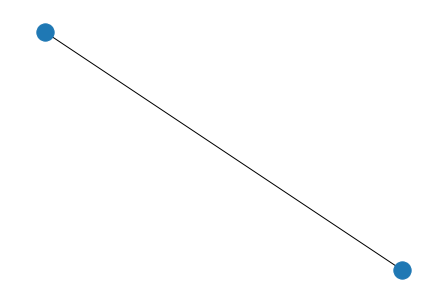

In [37]:
g = nx.Graph()
g.add_edge(0, 1)
nx.draw(g)
plt.show()

In [38]:
def Ising_PBC_dual(g,h):
  E = Z^Z
  B1 = X^I
  B2 = I^X


  H=(h*B1) + \
    (h*B2) + \
    (g*E) 
  return H

In [39]:
g=1
h=1
edge_list=[[0,1]]

In [40]:
def ansatz_ising(num_qubits,measure_list,depth):
  theta = ParameterVector("t",depth*(len(measure_list)+num_qubits))
  qr=QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  index = 0

  circuit.x(qr[i] for i in range (0,num_qubits))
  circuit.h(qr[i] for i in range (0,num_qubits))
  for _ in range (0,depth): 
    for edge in measure_list:
      circuit.cx(qr[edge[1]],qr[edge[0]])
      circuit.rz(theta[index],qr[edge[0]])
      circuit.cx(qr[edge[1]],qr[edge[0]])
      index+=1
    circuit.barrier()
    for i in range (0,num_qubits):
      circuit.rx(theta[index], qr[i])
      index+=1
  
    
  return circuit

In [41]:
ansatz=ansatz_ising(2,edge_list,1)
ansatz.draw()

┌───┐┌───┐┌───┐┌──────────┐┌───┐ ░ ┌──────────┐
q102_0: ┤ X ├┤ H ├┤ X ├┤ Rz(t[0]) ├┤ X ├─░─┤ Rx(t[1]) ├
        ├───┤├───┤└─┬─┘└──────────┘└─┬─┘ ░ ├──────────┤
q102_1: ┤ X ├┤ H ├──■────────────────■───░─┤ Rx(t[2]) ├
        └───┘└───┘                       ░ └──────────┘

In [42]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=20)
exact_result = exact_solver.compute_eigenvalues(Ising_PBC_dual(1,1))
print(exact_result.eigenvalues)


# Save ground state energy for later
gs_energy_ising= np.round(exact_result.eigenvalues[0], 4)

[-2.23606798 -1.          1.          2.23606798]


In [43]:
from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP,NFT

spsa = SPSA(maxiter=5,blocking=False, allowed_increase=1, trust_region=False,
                 learning_rate=None, perturbation=None, last_avg=10, resamplings=0,
                 perturbation_dims=None, second_order=False, regularization=None, 
                 hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None,
                 termination_checker=None)

cobyla=COBYLA(maxiter=30, disp=True, rhobeg=1.0, tol=1e-7, options=None)
slsqp=SLSQP(maxiter=100, disp=False, ftol=1e-06, tol=None, eps=1.4901161193847656e-08, options=None, max_evals_grouped=1)
nft=NFT(maxiter=50, maxfev=1024, disp=True, reset_interval=100, options=None)

In [44]:

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class Miti_CustomVQE(MinimumEigensolver):
    
    def __init__(self, sampler, circuit, optimizer,level_miti,time,callback=None):
        self._sampler = sampler
        self._circuit = circuit
        self._optimizer = optimizer
        self._level_miti=level_miti
        self._callback = callback
        self._time=time
        self._meas_fitters=None
        
    def compute_minimum_eigenvalue(self,ham):
                
        # Define objective function to classically minimize over
        def objective(x):
            qc_cal_bound=transpile(self._circuit.assign_parameters(x),basis_gates=['cx', 'id', 'rz', 'sx', 'x'],optimization_level=0)
            if self._meas_fitters is None or (time()-self._time)>1500:
                energy_mean,energy_error,meas_fitter=util_prova.miti_estimator(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti,meas_fitters=None)
                self._meas_fitters=meas_fitter
            else:
                energy_mean,energy_error,meas_fitter=util_prova.miti_estimator(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti,meas_fitters=self._meas_fitters)
            energy_mean=energy_mean.real
            energy_error=energy_error.real
            print('miti_sampler')
            print(energy_mean,energy_error)
            estimator_ideal = Estimator([self._circuit], [ham])
            job = estimator_ideal.run([self._circuit], [ham], [x])
            est_result = job.result()
            print('ideal_energy')
            print(est_result.values[0])

            if self._callback is not None:
                data=[energy_mean,energy_error,est_result.values[0],x]
                self._callback(data)  
            return energy_mean
            
        # Select an initial point for the ansatzs' parameters

       # Select an initial point for the ansatzs' parameters
        #x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [45]:


# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer,time, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback

        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            estimator_ideal = Estimator([self._circuit], [operators])
            job = estimator_ideal.run([self._circuit], [operators], [x])
            ideal_result = job.result().values[0]
            print('ideal_energy')
            print(ideal_result)

            # Save result information using callback function
            if self._callback is not None:

                self._callback([value,ideal_result,x])
                print('miti_energy')
                print(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        #x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [46]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Define instance of qiskit-terra's Estimator primitive
estimator = Sampler()


# Setup VQE algorithm
custom_vqe = Miti_CustomVQE(estimator,ansatz,cobyla,level_miti=2,time=time(),callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = 'ibmq_belem'
options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=[1,3]
options.shots=10000

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_0= []
def callback(value):
        intermediate_info_real_backend_0.append(value)




start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=0,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')



miti_sampler
-1.78096 0.04042092810131193
ideal_energy
-2.121320343559641
miti_sampler
-0.33196000000000003 0.05228626073094623
ideal_energy
-0.5511444335808832
miti_sampler
-1.5355999999999999 0.04738817556810423
ideal_energy
-1.7962649867431837
miti_sampler
-1.53916 0.04696769189168928
ideal_energy
-1.7962649867431832
miti_sampler
-1.50976 0.03807151165898196
ideal_energy
-1.788444099051595
miti_sampler
-1.8548399999999996 0.043998422977304476
ideal_energy
-2.2018816865991337
miti_sampler
-1.7946799999999998 0.0382043698750682
ideal_energy
-2.153457525825185
miti_sampler
-1.8912399999999998 0.0410247710137996
ideal_energy
-2.2018194990141455
miti_sampler
-1.81176 0.04273281012552872
ideal_energy
-2.1468674348615764
miti_sampler
-1.8888800000000001 0.043124877994503555
ideal_energy
-2.228616323122581
miti_sampler
-1.81996 0.04209394740533684
ideal_energy
-2.1862356607872915
miti_sampler
-1.82204 0.03958100967042921
ideal_energy
-2.2013652070688767
miti_sampler
-1.85352 0.0412531458293

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


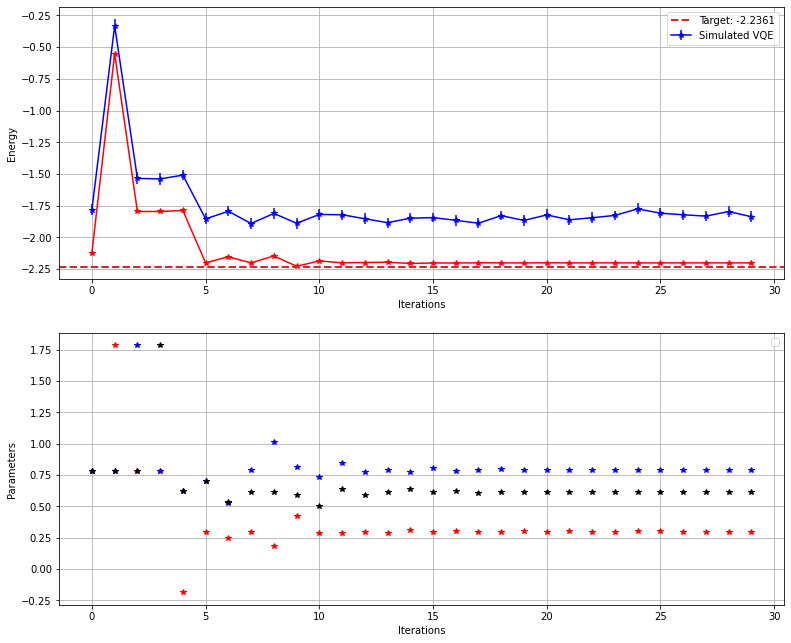

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_0:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.81854
0.023266181465809974


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_1= []
def callback(value):
        intermediate_info_real_backend_1.append(value)

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=1,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


miti_sampler
-1.77608 0.044006270425187066
ideal_energy
-2.121320343559641
miti_sampler
-0.3478000000000001 0.04582684357270022
ideal_energy
-0.5511444335808832
miti_sampler
-1.54204 0.048039116714338935
ideal_energy
-1.7962649867431837
miti_sampler
-1.4990799999999997 0.04687987253587186
ideal_energy
-1.7962649867431832
miti_sampler
-1.4913199999999998 0.03948424640645574
ideal_energy
-1.7943628761907273
miti_sampler
-1.8449200000000001 0.03861079472618705
ideal_energy
-2.202031939104598
miti_sampler
-1.79228 0.03967749580643147
ideal_energy
-2.157671086412882
miti_sampler
-1.84484 0.036857076411900225
ideal_energy
-2.2012430587513974
miti_sampler
-1.84396 0.04143308349813306
ideal_energy
-2.118968134451041
miti_sampler
-1.8788799999999999 0.04364334112427458
ideal_energy
-2.23042342782733
miti_sampler
-1.9201599999999999 0.043435751286191884
ideal_energy
-2.234440715553636
miti_sampler
-1.8892799999999998 0.03840399639068192
ideal_energy
-2.2126377954473884
miti_sampler
-1.9202800000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


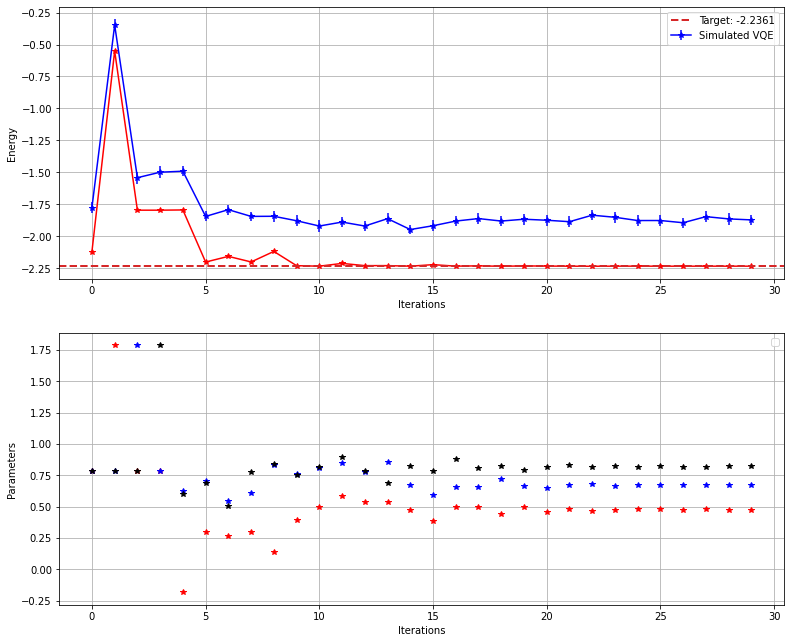

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_1:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()



In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.864935
0.019277746608089674


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_2= []
def callback(value):
        intermediate_info_real_backend_2.append(value)

options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=2,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


C:\Users\asus\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


miti_sampler
-1.9620000000000002 0.041074665710938
ideal_energy
-2.121320343559641
miti_sampler
-0.49863999999999997 0.04882077175856647
ideal_energy
-0.5511444335808832
miti_sampler
-1.6614 0.047414059742069026
ideal_energy
-1.7962649867431837
miti_sampler
-1.7145199999999998 0.04378487298189656
ideal_energy
-1.7962649867431832
miti_sampler
-1.66968 0.03147311129669066
ideal_energy
-1.7990055702983596
miti_sampler
-2.03632 0.03711317495313546
ideal_energy
-2.20213235517776
miti_sampler
-1.9942399999999998 0.03585162165802551
ideal_energy
-2.157751930733911
miti_sampler
-2.01536 0.03563295883170582
ideal_energy
-2.201176299964529
miti_sampler
-1.9549200000000002 0.03564516740294081
ideal_energy
-2.1242346911279055
miti_sampler
-2.08076 0.041576465085184824
ideal_energy
-2.2290421177131967
miti_sampler
-2.0546800000000003 0.03846187616806212
ideal_energy
-2.2294277973876557
miti_sampler
-2.0395199999999996 0.03824048501101355
ideal_energy
-2.212533955287406
miti_sampler
-2.0709999999999

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


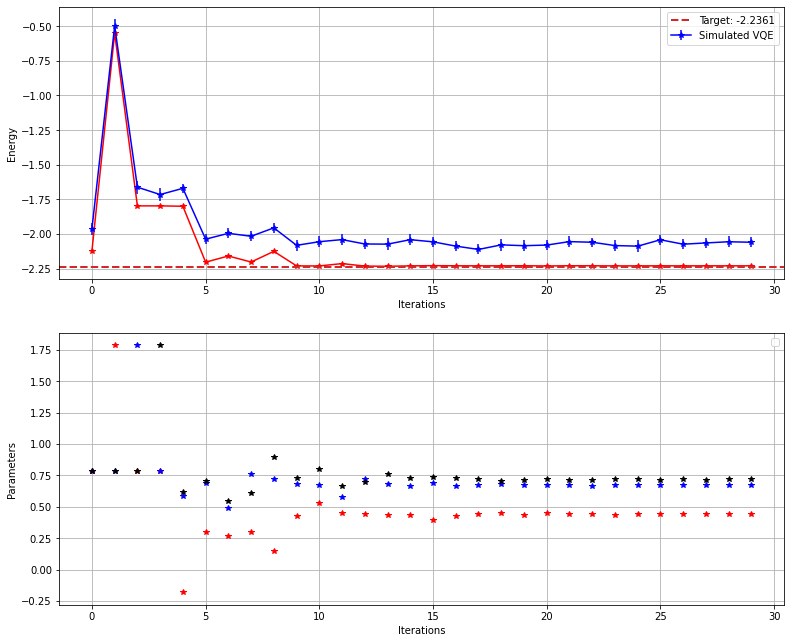

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_2:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-2.064795
0.015127941036373795


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_3= []
def callback(value):
        intermediate_info_real_backend_3.append(value)



start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=3,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


miti_sampler
-1.793113880084032 0.0447839894061725
ideal_energy
-2.121320343559641
miti_sampler
-0.37985542552159457 0.047755209751409
ideal_energy
-0.5511444335808832
miti_sampler
-1.5085796085081022 0.04126582320270594
ideal_energy
-1.7962649867431837
miti_sampler
-1.560407531612628 0.050659096498896564
ideal_energy
-1.7962649867431832
miti_sampler
-1.5446972239033174 0.034329653443757976
ideal_energy
-1.7966887630886206
miti_sampler
-1.8914199843239803 0.03952315292221727
ideal_energy
-2.2020914300534464
miti_sampler
-1.8027208963218389 0.039234294987883944
ideal_energy
-2.0796762801478867
miti_sampler
-1.9084438589071757 0.03877424365767298
ideal_energy
-2.20006608159177
miti_sampler
-1.6820377812854963 0.03985113349891595
ideal_energy
-1.9477474071815775


C:\Users\asus\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


miti_sampler
-1.8788649581993844 0.04665524501076205
ideal_energy
-2.2151875801669236
miti_sampler
-1.8202878662082336 0.038726928933469816
ideal_energy
-2.150773539954818
miti_sampler
-1.8606684263206317 0.043140366652290804
ideal_energy
-2.1913620988481726
miti_sampler
-1.8945973179680546 0.03936377973665229
ideal_energy
-2.217309575047733
miti_sampler
-1.859284039214488 0.03558824524994952
ideal_energy
-2.2011413415848162
miti_sampler
-1.8519615386284498 0.04079202914139145
ideal_energy
-2.1937254832287314
miti_sampler
-1.8817113603722044 0.04208741048026934
ideal_energy
-2.201269136985898
miti_sampler
-1.8753715262863477 0.042162339547583944
ideal_energy
-2.2050698007190865
miti_sampler
-1.8556986124556016 0.042688993678981345
ideal_energy
-2.195190167706684
miti_sampler
-1.862482708953659 0.03837809163163895
ideal_energy
-2.199899577016261
miti_sampler
-1.8903047611808392 0.04030846040380795
ideal_energy
-2.2001961700527946
miti_sampler
-1.8553312152620738 0.04284309427124337
idea

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


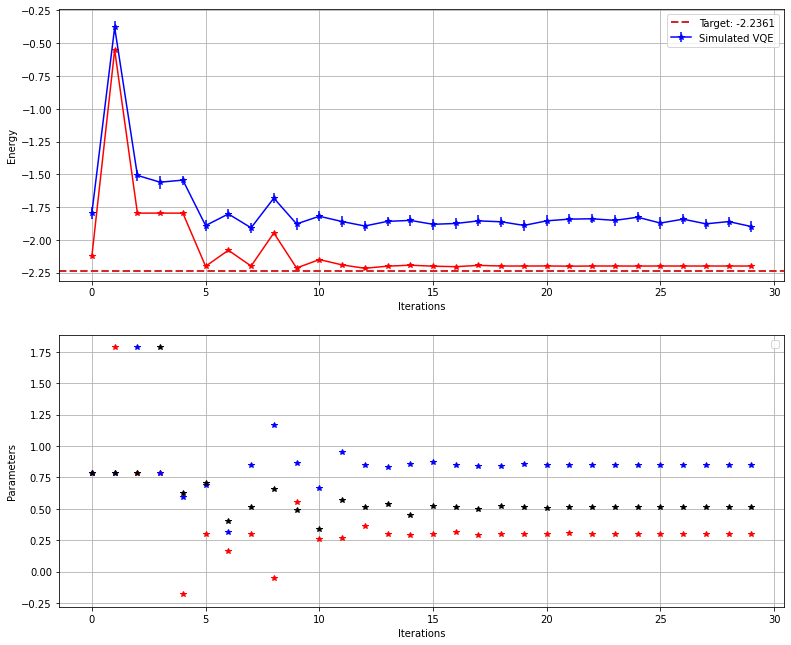

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_3:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.8589845127422295
0.023350428837356465


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_4= []
def callback(value):
        intermediate_info_real_backend_4.append(value)



start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=4,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


miti_sampler
-2.0022 0.04316833684684235
ideal_energy
-2.121320343559641
miti_sampler
-0.53232 0.05328138626620914
ideal_energy
-0.5511444335808832
miti_sampler
-1.7004400000000004 0.043038075216804784
ideal_energy
-1.7962649867431837
miti_sampler
-1.71048 0.04282028891608675
ideal_energy
-1.7962649867431832
miti_sampler
-1.7072799999999997 0.03437602391796006
ideal_energy
-1.8068286900006392
miti_sampler
-2.0792800000000002 0.03504050134763882
ideal_energy
-2.2022173562313383
miti_sampler
-1.9547999999999996 0.03477446870146815
ideal_energy
-2.0927038253558403
miti_sampler
-2.0914 0.028557853918110925
ideal_energy
-2.201866095405818
miti_sampler
-1.85388 0.036948612964494344
ideal_energy
-1.9794483983689521
miti_sampler
-2.1044 0.0359313177024825
ideal_energy
-2.222526188671531
miti_sampler
-2.038 0.03191023122985568
ideal_energy
-2.196496126186098
miti_sampler
-2.0498 0.03718702867991493
ideal_energy
-2.219846108400208
miti_sampler
-2.0574399999999997 0.03836924789038052
ideal_energy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


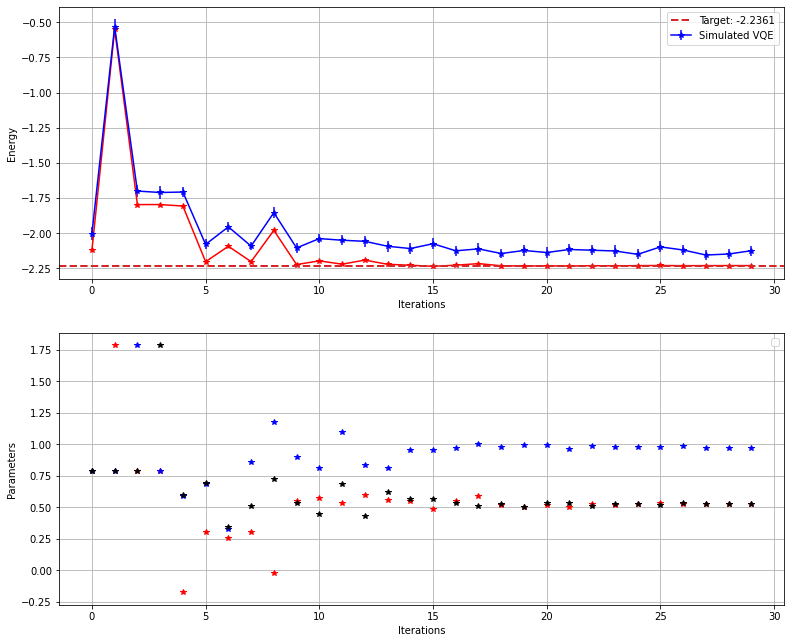

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_4:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-2.13001
0.01950149884349561


ideal_energy
-2.0381637819204976
miti_energy
-1.704
ideal_energy
-0.607302805030162
miti_energy
-0.43699999999999994
ideal_energy
-2.195697649975313
miti_energy
-1.8595
ideal_energy
-1.831265641618089
miti_energy
-1.538
ideal_energy
-1.5489800053465075
miti_energy
-1.33
ideal_energy
-1.8479347579512262
miti_energy
-1.5465
ideal_energy
-2.2053825658490274
miti_energy
-1.827
ideal_energy
-2.154345028020621
miti_energy
-1.803
ideal_energy
-2.2184638329680038
miti_energy
-1.909
ideal_energy
-2.208747899278045
miti_energy
-1.849
ideal_energy
-2.2202693238397138
miti_energy
-1.8424999999999998
ideal_energy
-2.1944273499517477
miti_energy
-1.8989999999999998
ideal_energy
-2.2235149933959257
miti_energy
-1.876
ideal_energy
-2.2141984579116474
miti_energy
-1.8495
ideal_energy
-2.2174704501526845
miti_energy
-1.891
ideal_energy
-2.2210819866473317
miti_energy
-1.8435
ideal_energy
-2.214939178996645
miti_energy
-1.8065
ideal_energy
-2.2158196738163487
miti_energy
-1.8519999999999999
ideal_energy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ideal_energy
-2.2184151878653564
miti_energy
-1.8584999999999998
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 30,
    'eigenstate': None,
    'eigenvalue': -1.909,
    'optimal_circuit': None,
    'optimal_parameters': array([ 0.37428816,  1.79956741, -0.01040232]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 1004.33
[array([0.78539816, 0.78539816, 0.78539816]), array([1.78539816, 0.78539816, 0.78539816]), array([0.78539816, 1.78539816, 0.78539816]), array([0.78539816, 0.78539816, 1.78539816]), array([-0.17616931,  0.58799252,  0.5945605 ]), array([0.30461443, 0.68669534, 0.68997933]), array([0.25661937, 0.32887226, 0.34406155]), array([0.30461443, 0.86045662, 0.51023779]), array([-0.02122268,  1.17499996,  0.72211668]), array([0.55056719, 0.90027606, 0.53077197]), array([0.57204636, 0.81174203, 0.4451836 ]), array([0.53075544, 1.09443741, 0.68700535]

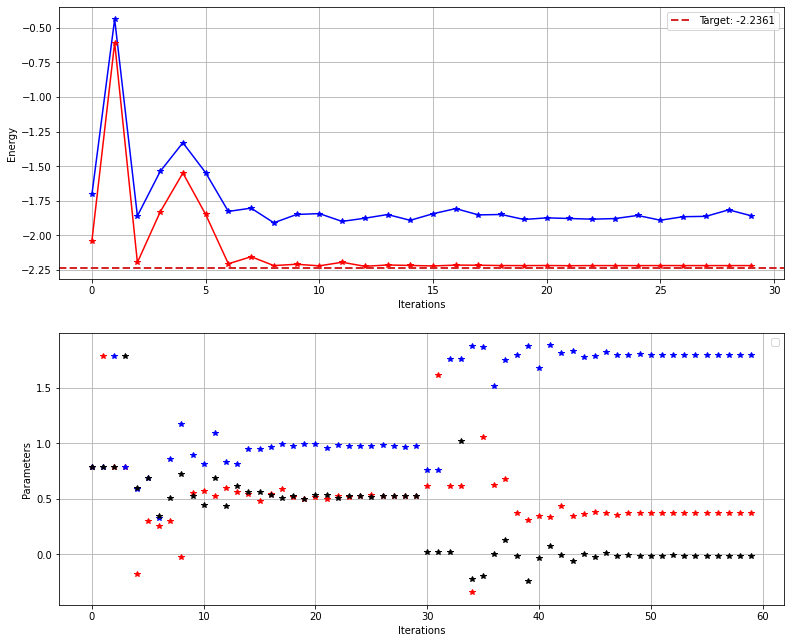

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_raw= []
def callback(value):
        intermediate_info_real_backend_raw.append(value)


options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=[1,2]
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameteres=[]
ideal_energy=[]
for data in intermediate_info_real_backend_raw:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

-1.8636875
0.02306038269413582


In [ ]:
# Define a simple callback function
intermediate_info_real_backend_meas= []
def callback(value):
        intermediate_info_real_backend_meas.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 1
options.optimization_level = 3
options.initial_layout=[1,2]
options.simulator = {
    "noise_model": backend_noise_model
}
options.shots=10000
start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_meas:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

NameError: name 'backend_noise_model' is not defined

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_zne= []
def callback(value):
        intermediate_info_real_backend_zne.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 2
options.optimization_level = 3
options.initial_layout=[1,2]
options.simulator = {
    "noise_model": backend_noise_model
}
options.shots=10000
start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_PEC= []
def callback(value):
        intermediate_info_real_backend_PEC.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 3
options.optimization_level = 3
options.initial_layout=[1,2]
options.simulator = {
    "noise_model": backend_noise_model
}
options.shots=10000
start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)
    ansatz=ansatz_ising(2,edge_list,1)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameteres=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
en=energies_miti[-8:]
e=statistics.mean(en)
de=statistics.stdev(en)
print(e)
print(de)